In [1]:
import sys, string, pandas as pd, numpy as np, matplotlib.pyplot as plt

# Exercise 1

## (a) Univariate decision Boundary

In [2]:
from scipy.stats import norm

train_data = pd.read_csv("Dementia_train.csv")
test_data = pd.read_csv("Dementia_test.csv")
train_data_filtered = train_data[train_data['DX'] != 'MCI']
test_data_filtered = test_data[test_data['DX'] != 'MCI']
train_cn = train_data_filtered[train_data_filtered['DX'] == 'CN']
train_dementia = train_data_filtered[train_data_filtered['DX'] == 'Dementia']

features = ['ADAS13', 'ABETA', 'TAU']

means_cn = train_cn[features].mean()
means_dementia = train_dementia[features].mean()
stds_cn = train_cn[features].std()
stds_dementia = train_dementia[features].std()

decision_boundaries = (means_cn + means_dementia) / 2

def classify_gaussian(value, mean_cn, std_cn, mean_dementia, std_dementia):
    likelihood_cn = norm.pdf(value, loc=mean_cn, scale=std_cn)
    likelihood_dementia = norm.pdf(value, loc=mean_dementia, scale=std_dementia)
    return 'CN' if likelihood_cn >= likelihood_dementia else 'Dementia'

results = {}
for feature in features:
    predictions = test_data_filtered[feature].apply(
        classify_gaussian, 
        args=(means_cn[feature], stds_cn[feature], means_dementia[feature], stds_dementia[feature])
    )
    true_labels = test_data_filtered['DX']
    
    tp = ((predictions == 'Dementia') & (true_labels == 'Dementia')).sum()
    tn = ((predictions == 'CN') & (true_labels == 'CN')).sum()
    fp = ((predictions == 'Dementia') & (true_labels == 'CN')).sum()
    fn = ((predictions == 'CN') & (true_labels == 'Dementia')).sum()
    
    accuracy = (tp + tn) / len(test_data_filtered)
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    results[feature] = {
        "Accuracy": accuracy,
        "Sensitivity": sensitivity,
        "Specificity": specificity
    }

print("Means (CN):\n", means_cn)
print("Means (Dementia):\n", means_dementia)
print("Standard Deviations (CN):\n", stds_cn)
print("Standard Deviations (Dementia):\n", stds_dementia)
print("\nDecision Boundaries:\n", decision_boundaries)

print("\nPerformance Metrics:")
for feature, metrics in results.items():
    print(f"\n{feature}:")
    for metric, value in metrics.items():
        print(f"  {metric}: {value:.2f}")


Means (CN):
 ADAS13       9.188898
ABETA     1221.785039
TAU        230.633071
dtype: float64
Means (Dementia):
 ADAS13     30.352143
ABETA     671.167143
TAU       380.577143
dtype: float64
Standard Deviations (CN):
 ADAS13      4.265873
ABETA     437.111534
TAU        95.567115
dtype: float64
Standard Deviations (Dementia):
 ADAS13      9.045188
ABETA     312.756442
TAU       156.774314
dtype: float64

Decision Boundaries:
 ADAS13     19.770520
ABETA     946.476091
TAU       305.605107
dtype: float64

Performance Metrics:

ADAS13:
  Accuracy: 0.98
  Sensitivity: 0.96
  Specificity: 0.99

ABETA:
  Accuracy: 0.75
  Sensitivity: 0.91
  Specificity: 0.64

TAU:
  Accuracy: 0.75
  Sensitivity: 0.54
  Specificity: 0.90


## (b) Linear Regression Boundary

C:\Users\kajan\AppData\Local\Temp\ipykernel_16032\938605343.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_filtered['DX_encoded'] = train_data_filtered['DX'].map(label_mapping)
C:\Users\kajan\AppData\Local\Temp\ipykernel_16032\938605343.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_filtered['DX_encoded'] = test_data_filtered['DX'].map(label_mapping)


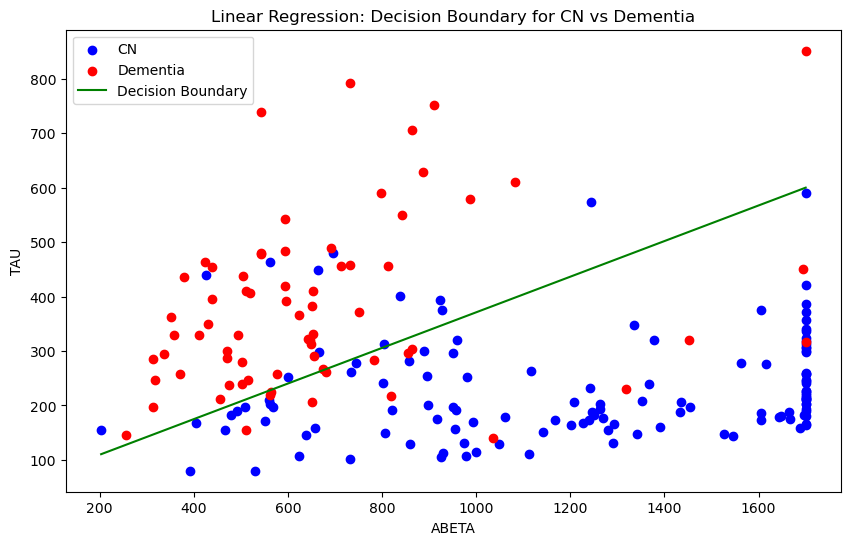

Model Performance on Test Data:
Accuracy: 0.85
Sensitivity: 0.82
Specificity: 0.87


In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, confusion_matrix

label_mapping = {'CN': 0, 'Dementia': 1}
train_data_filtered['DX_encoded'] = train_data_filtered['DX'].map(label_mapping)
test_data_filtered['DX_encoded'] = test_data_filtered['DX'].map(label_mapping)

features = ['ABETA', 'TAU']
X_train = train_data_filtered[features]
y_train = train_data_filtered['DX_encoded']
X_test = test_data_filtered[features]
y_test = test_data_filtered['DX_encoded']

model = LinearRegression()
model.fit(X_train, y_train)

coef = model.coef_
intercept = model.intercept_

x_vals = np.linspace(X_train['ABETA'].min(), X_train['ABETA'].max(), 100)
decision_boundary = -(coef[0] / coef[1]) * x_vals - (intercept - 0.5) / coef[1]

plt.figure(figsize=(10, 6))
plt.scatter(X_train['ABETA'][y_train == 0], X_train['TAU'][y_train == 0], color='blue', label='CN')
plt.scatter(X_train['ABETA'][y_train == 1], X_train['TAU'][y_train == 1], color='red', label='Dementia')
plt.plot(x_vals, decision_boundary, color='green', label='Decision Boundary')
plt.xlabel('ABETA')
plt.ylabel('TAU')
plt.title('Linear Regression: Decision Boundary for CN vs Dementia')
plt.legend()
plt.show()

def classify(features, coef, intercept, threshold=0.5):
    """
    Classify a set of features (ABETA, TAU) based on a linear regression model.
    """
    decision_value = np.dot(features, coef) + intercept
    return (decision_value >= threshold).astype(int)

def calculate_metrics(y_true, y_pred):
    """
    Calculate accuracy, sensitivity, and specificity based on predictions.
    """
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    accuracy = (tp + tn) / len(y_true)
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    return accuracy, sensitivity, specificity

y_pred = classify(X_test, coef, intercept)
accuracy, sensitivity, specificity = calculate_metrics(y_test, y_pred)

print("Model Performance on Test Data:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Sensitivity: {sensitivity:.2f}")
print(f"Specificity: {specificity:.2f}")


## (c) Multimodal Boundary

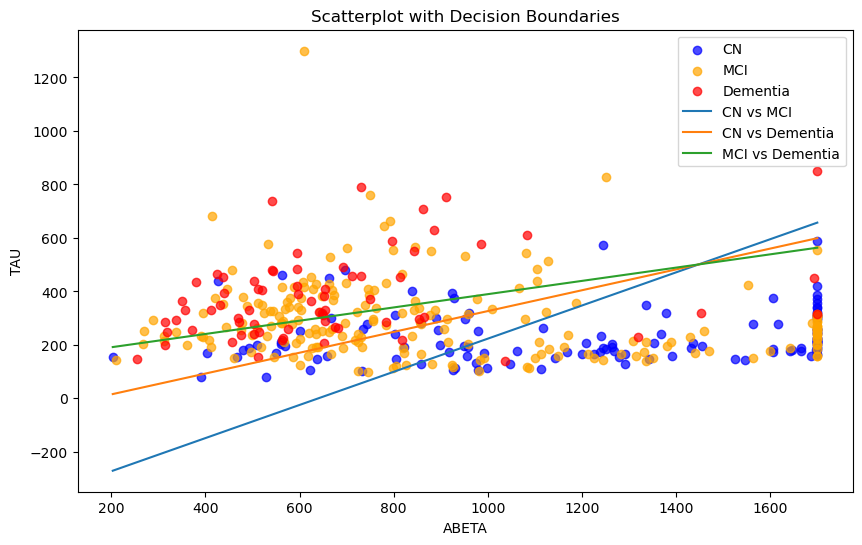

Accuracy: 0.84
Sensitivity: 0.91
Specificity: 0.80


C:\Users\kajan\AppData\Local\Temp\ipykernel_16032\693249369.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Prediction'] = data[['ABETA', 'TAU']].apply(lambda row: classify(row), axis=1)


In [4]:

groups = ['CN', 'MCI', 'Dementia']
means = {}
for group in groups:
    means[group] = train_data[train_data['DX'] == group][['ABETA', 'TAU']].mean()

cov_matrix = train_data[['ABETA', 'TAU']].cov()

def linear_boundary(mean1, mean2, cov_matrix, prior1=0.33, prior2=0.33):
    """
    Compute coefficients for the linear decision boundary between two classes.
    """
    cov_inv = np.linalg.inv(cov_matrix)
    mean_diff = mean1 - mean2
    a = cov_inv @ mean_diff
    b = (
        -0.5 * (mean1.T @ cov_inv @ mean1 - mean2.T @ cov_inv @ mean2)
        + np.log(prior1 / prior2)
    )
    return a[0], a[1], b

boundaries = {}
pairs = [('CN', 'MCI'), ('CN', 'Dementia'), ('MCI', 'Dementia')]
for pair in pairs:
    mean1 = means[pair[0]].values  
    mean2 = means[pair[1]].values
    boundaries[pair] = linear_boundary(mean1, mean2, cov_matrix)

plt.figure(figsize=(10, 6))
colors = {'CN': 'blue', 'MCI': 'orange', 'Dementia': 'red'}
for group in groups:
    subset = train_data[train_data['DX'] == group]
    plt.scatter(
        subset['ABETA'], subset['TAU'], label=group, alpha=0.7, color=colors[group]
    )

x_vals = np.linspace(train_data['ABETA'].min(), train_data['ABETA'].max(), 200)
for pair, (a1, a2, b) in boundaries.items():
    y_vals = -(a1 * x_vals + b) / a2 
    plt.plot(x_vals, y_vals, label=f"{pair[0]} vs {pair[1]}")

plt.xlabel('ABETA')
plt.ylabel('TAU')
plt.title('Scatterplot with Decision Boundaries')
plt.legend()
plt.show()

def calculate_metrics(data, mean_cn, mean_dementia, cov_matrix):
    """
    Calculate accuracy, sensitivity, and specificity for CN vs Dementia.
    """
    cov_inv = np.linalg.inv(cov_matrix)
    decision_boundary = linear_boundary(mean_cn, mean_dementia, cov_matrix)
    a1, a2, b = decision_boundary

    def classify(point):
        """
        Classify a point as CN or Dementia based on the decision boundary.
        """
        return 'Dementia' if (a1 * point[0] + a2 * point[1] + b) <= 0 else 'CN'

    data['Prediction'] = data[['ABETA', 'TAU']].apply(lambda row: classify(row), axis=1)

    true_positive = ((data['DX'] == 'Dementia') & (data['Prediction'] == 'Dementia')).sum()
    true_negative = ((data['DX'] == 'CN') & (data['Prediction'] == 'CN')).sum()
    false_positive = ((data['DX'] == 'CN') & (data['Prediction'] == 'Dementia')).sum()
    false_negative = ((data['DX'] == 'Dementia') & (data['Prediction'] == 'CN')).sum()

    accuracy = (true_positive + true_negative) / len(data)
    sensitivity = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0
    specificity = true_negative / (true_negative + false_positive) if (true_negative + false_positive) > 0 else 0

    return accuracy, sensitivity, specificity

mean_cn = means['CN'].values
mean_dementia = means['Dementia'].values

accuracy, sensitivity, specificity = calculate_metrics(test_data_filtered, mean_cn, mean_dementia, cov_matrix)

print(f"Accuracy: {accuracy:.2f}")
print(f"Sensitivity: {sensitivity:.2f}")
print(f"Specificity: {specificity:.2f}")


# Exercise 2: Logistic Regression

## (a) Logistic Regression with IWLS

In [5]:
import sys, string, pandas as pd, numpy as np, matplotlib.pyplot as plt
from scipy.special import expit
from sklearn.linear_model import LogisticRegression 

def sigmoid(value):
    return expit(value)

In [6]:
def fit_LogReg_IWLS(y, features, eps=0.0000001):
    #sample size
    N = features.shape[0]
    #feature dim
    p = features.shape[1] + 1
    #initalize beta with 0s
    betas = np.zeros(p)

    #add column of 1 to features to get our X matrix
    X = np.c_[np.ones(N),features]
    #compute predictions for class 1: linear combination between input (X) and
    # coefficients (betas) passed through the sigmoid function
    prob1 = sigmoid( X @ betas)
    #compute predictions for class 0 (1.0 - prob1)
    prob0 = 1.0 - prob1
    #COMPLETE THIS CODE:
    W = np.diag(prob1 * prob0) 
    old_loglike = 100000
    #compute LogLikelihood:
    #COMPLETE THIS CODE:
    loglike = np.sum(y * np.log(prob1) + (1 - y) * np.log(prob0))
    niter=0
    while np.abs(loglike - old_loglike) > eps:
        #update betas:
        #COMPLETE THIS CODE
        z = X @ betas + np.linalg.pinv(W) @ (y - prob1)
        #COMPLETE THIS CODE
        betas_new = np.linalg.pinv(X.T @ W @ X) @ (X.T @ W @ z)
        betas = betas_new
        prob1 = sigmoid( X @ betas)
        prob0 = 1.0 - prob1
        #make both probs 'stable'
        prob1[prob1 == 0.0] = 10**-10
        prob0[prob0 == 0.0] = 10**-10

        #COMPLETE THIS CODE:
        W = np.diag(prob1 * prob0)
        old_loglike = loglike
        #COMPLETE THIS CODE:
        loglike = np.sum(y * np.log(prob1) + (1 - y) * np.log(prob0))
        niter += 1
    print("Total iterations: " + str(niter))
    return(betas)

c:\Users\kajan\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Total iterations: 26


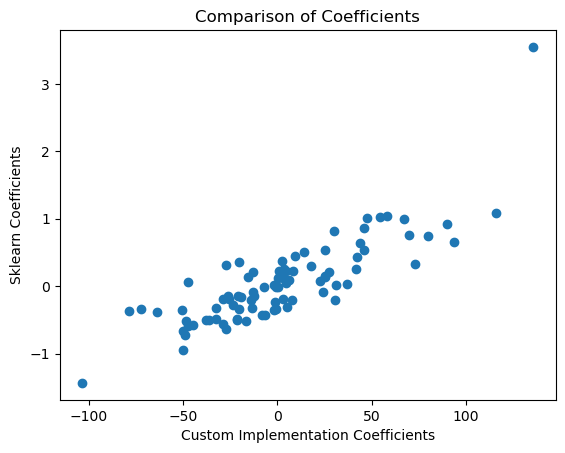

Custom coefficients: [ 135.53663127   -0.63214814  -78.42120385  115.91420113   58.06725894
  -47.53668911   93.32385079  -47.11209773   36.77644053  -72.37764782
    3.04003928  -13.78088105  -20.47466035   73.03064398   45.82237297
  -12.66116603    6.24445052   25.20291114    4.55886984   -7.00649086
  -27.19679852   79.78385786    8.32105946   67.22142646  -25.96386327
    4.72883109   47.71454714  -44.58036216    5.1469331   -15.33006714
   22.65955491  -32.34123814    0.2836591    69.64266932   17.79784725
   45.90251498   -6.74925187  -63.7941366    89.67705564   43.98846898
 -103.33839386  -13.51382401  -13.15046228  -49.15127854  -50.47033795
  -19.26763249    2.57387964  -37.99940534  -28.8390802    24.25434989
   -8.09331844  -25.61214424    3.41865126   13.86542932   31.14524018
  -23.26351335  -21.45751362  -32.69410849   27.35092622  -36.32517655
  -21.56389117  -16.67526952   -1.88461547   41.75352969    3.02085804
   -1.77761881  -48.3968743   -21.01644672    7.7513398 

In [7]:
# Load the dataset
data = pd.read_csv('LogReg_data.csv')

# Extract features and target
X = data.drop(columns=['DX']).values  # Features
y = data['DX'].values  # Target (PD status)

# Fit model using custom implementation
custom_betas = fit_LogReg_IWLS(y, X)

# Fit model using sklearn
sklearn_model = LogisticRegression(fit_intercept=True)
sklearn_model.fit(X, y)
sklearn_betas = np.concatenate([[sklearn_model.intercept_[0]], sklearn_model.coef_[0]])

# Scatter plot of coefficients
plt.scatter(custom_betas, sklearn_betas)
plt.xlabel("Custom Implementation Coefficients")
plt.ylabel("Sklearn Coefficients")
plt.title("Comparison of Coefficients")
plt.show()

# Print coefficients for comparison
print("Custom coefficients:", custom_betas)
print("Sklearn coefficients:", sklearn_betas)


Roughly linear trend indicating custom implementation and sklearn models produce generally proportional coefficients, though there are scaling issues present. There are outliers, notably the one with the largest positive custom coefficient. 

Despite scaling issues the custom model outperformed significantly in specificity, performed similarly ( slightly better ) in accuract, but underperformed in sensitivity, suggesting better performance at identifying true negatives, but misses some true positives

Issues may be caused by features like ABETA and Tau have different scales, like mean ABETA for CN is 1221.78 whereas for ADAS13 is 9.18. Without normalization or standardization features with large values dominate the optimization which causes coefficient magnitudes in the custom implementation.The custom implementation also has no regularisation to prevent overly large coefficients, whereas according to documentation Sklearn uses L2 regularisation by default. 

## (b) Logistic Regression with gradient descent

In [8]:
import numpy as np
from scipy.special import expit

def sigmoid(value):
    return expit(value)

In [9]:
#implements gradient descent for a fixed number of iterations
#alpha is the learning rate
#retunrs the beta coefficiencts
#and the loss history
def fit_LogReg_GRAD(y, features, alpha=0.001, max_iter=1000):
    #sample size
    N = features.shape[0]
    #feature dim
    p = features.shape[1] + 1
    #initalize beta with 0s
    betas = np.zeros(p)

    #add column of 1 to X
    X = np.c_[np.ones(N),features]
    #compute predictions for class 1
    prob1 = sigmoid( X @ betas)
    #compute predictions for class 2
    prob0 = 1.0 - prob1

    #compute the cost (J) of the current solution
    #COMPLETE THIS LINE
    cost = -np.sum(y * np.log(prob1) + (1 - y) * np.log(prob0))
    loss = []
    niter = 0
    while niter < max_iter:
        #beta update (one step of the gradient descent)
        #COMPLETE THIS LINE
        betas -= alpha * (X.T @ (prob1 - y))
        prob1 = sigmoid( X @ betas)
        prob0 = 1.0 - prob1
        #make both probs 'stable'
        prob1[prob1 == 0.0] = 10**-10
        prob0[prob0 == 0.0] = 10**-10

        #recompute cost
        #COMPLETE THIS LINE
        cost = -np.sum(y * np.log(prob1) + (1 - y) * np.log(prob0))
        loss.append(cost)
        niter += 1
    res = {}
    res["betas"] = betas
    res["loss"] = loss
    print("total iterations: " + str(niter))
    return(res)

In [10]:
# Load data
data = pd.read_csv('LogReg_data.csv')

# Assuming 'label' column contains 0 for Healthy and 1 for PD
y = data['DX'].values
X = data.drop(columns=['DX']).values

# Train using gradient descent implementation
result = fit_LogReg_GRAD(y, X, alpha=0.1, max_iter=3000)
grad_desc_betas = result["betas"]

# Compare coefficients
comparison = pd.DataFrame({
    'Custom Gradient Descent Betas': grad_desc_betas,
    'Sklearn Logistic Regression Betas': custom_betas
})

# Display the comparison in a readable format
print("Coefficient Comparison:")
print(comparison)

# Print the final loss value
print("Final loss from gradient descent:", result["loss"][-1])


total iterations: 3000
Coefficient Comparison:
    Custom Gradient Descent Betas  Sklearn Logistic Regression Betas
0                     3663.514235                         135.536631
1                     -110.786208                          -0.632148
2                      600.870366                         -78.421204
3                     2733.938974                         115.914201
4                     3083.583810                          58.067259
..                            ...                                ...
81                   -1267.096931                          -0.486061
82                    -473.357734                           0.201067
83                   -1019.381237                         -20.084056
84                   -2264.401020                         -12.462050
85                   -1981.387455                          30.327407

[86 rows x 2 columns]
Final loss from gradient descent: 2609.5991093510665


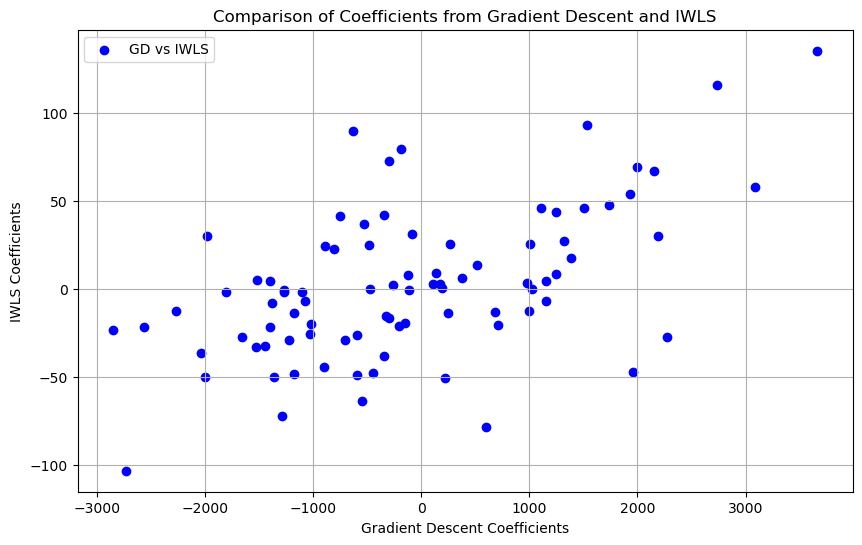

In [11]:
import matplotlib.pyplot as plt

# Scatter plot to compare coefficients from Gradient Descent and IWLS
plt.figure(figsize=(10, 6))
plt.scatter(grad_desc_betas, custom_betas, color='blue', label='GD vs IWLS')
plt.xlabel('Gradient Descent Coefficients')
plt.ylabel('IWLS Coefficients')
plt.title('Comparison of Coefficients from Gradient Descent and IWLS')
plt.legend(loc='best')
plt.grid(True)
plt.show()


The points do not lie perfectly along a diagonal line with slope 1, indicating discrepancies between the two methods. Most coefficients have a significant difference in magnitude, especially at extreme values. Differences could be due to convergence issues in the gradient descent (e.g., insufficient iterations or suboptimal learning rate, or numerical stability differences in how the two methods compute the coefficients)

## (c) Logistic Regression with Gradient Descent and Momentum

In [20]:
#implements gradient descent with momentum for a fixed number of iterations
#alpha is the learning rate
#gamma is the factor for momentum
#returns the beta coefficiencts
#and the loss history

def fit_LogReg_GRAD_momentum(y, features, alpha=0.001, gamma=0.9, max_iter=1000):
    #sample size
    N = features.shape[0]
    #feature dim
    p = features.shape[1] + 1
    #initalize beta with 0s
    betas = np.zeros(p)

    #add column of 1 to X
    X = np.c_[np.ones(N),features]
    #compute predictions for class 1
    prob1 = sigmoid( X @ betas)
    #compute predictions for class 2
    prob0 = 1.0 - prob1

    #compute the cost (J) of the current solution
    #COMPLETE THIS LINE
    cost = -np.sum(y * np.log(prob1) + (1 - y) * np.log(prob0))
    niter = 0
    loss = []
    while niter < max_iter:
        #beta update (one step of the gradient descent)
        #COMPLETE THIS LINE
        betas -= np.zeros(p) * gamma + alpha * X.T @ (prob1 - y) #np.zeros(p) = velocity//X.T @ (prob1 - y) = gradient
        prob1 = sigmoid( X @ betas)
        prob0 = 1.0 - prob1
        #make both probs 'stable'
        prob1[prob1 == 0.0] = 10**-10
        prob0[prob0 == 0.0] = 10**-10

        old_cost = cost
        #recompute cost
        #COMPLETE THIS LINE
        cost = -np.sum(y * np.log(prob1) + (1 - y) * np.log(prob0))
        niter += 1
        loss.append(cost)
        
    res = {}
    res["betas"] = betas
    res["loss"] = loss
    print("total iterations: " + str(niter))
    return(res)

total iterations: 100
total iterations: 100


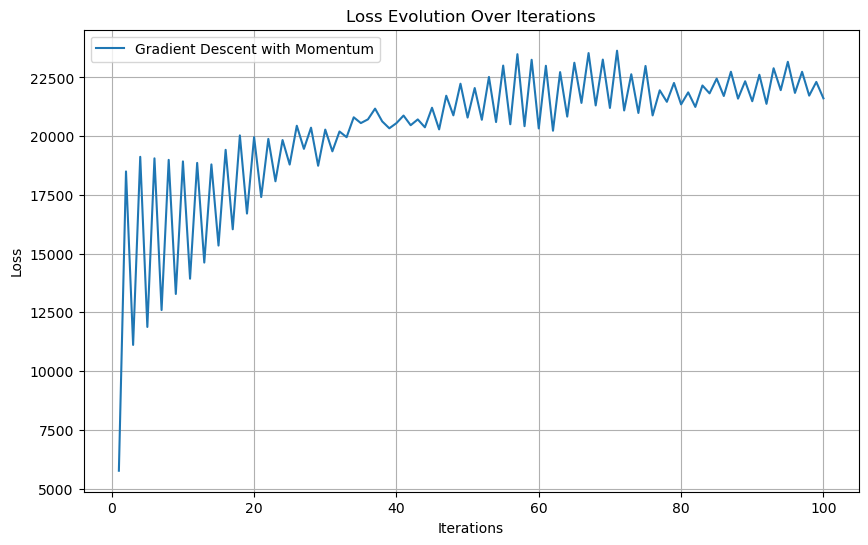

In [25]:
# Load the dataset
data = pd.read_csv('Syn_Momentum.csv')

# Extract features and target
X = data[['X1', 'X2']].values  # Features
y = data['y'].values  # Target

# Run standard gradient descent (from part b)
grad_result = fit_LogReg_GRAD(y, X, alpha=0.001, max_iter=100)
grad_betas = grad_result["betas"]

# Run gradient descent with momentum
momentum_result = fit_LogReg_GRAD_momentum(y, X, alpha=0.001, gamma=0.9, max_iter=100)
momentum_betas = momentum_result["betas"]

# Extract loss histories
grad_loss = grad_result["loss"]
momentum_loss = momentum_result["loss"]

# Plot the loss evolution
plt.figure(figsize=(10, 6))
plt.plot(range(1, 101), momentum_loss, label='Gradient Descent with Momentum')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss Evolution Over Iterations')
plt.legend()
plt.grid(True)
plt.show()


In [23]:
beta_comparison = pd.DataFrame({
    'Beta Index': range(len(grad_betas)),
    'Standard GD': grad_betas,
    'Momentum GD': momentum_betas,
    'Difference': grad_betas - momentum_betas
})

# Print the comparison
print("Beta Coefficients Comparison:")
print(beta_comparison)

Beta Coefficients Comparison:
   Beta Index  Standard GD  Momentum GD    Difference
0           0    -0.476042    -0.476042  1.276756e-14
1           1   -42.191510   -42.191510 -2.202682e-13
2           2    46.755023    46.755023 -3.552714e-14


## (d) Competing Objectives

In [ ]:
#implements gradient descent for a fixed number of iterations
#y is the target variable
#y2 is the variable to be avoided
#delta is the tradoff between the loss for objective1 (i.e., fit y) and objective2 (i.e., don't fit y2)
#alpha is the learning rate
#returns the beta coefficiencts
#and the loss history

def fit_LogReg_GRAD_competing(y, y2, features, delta, alpha=0.001, max_iter=1000):
    #sample size
    N = features.shape[0]
    #feature dim
    p = features.shape[1] + 1
    #initalize beta with 0s
    betas = np.zeros(p)

    #add column of 1 to X
    X = np.c_[np.ones(N),features]
    #compute predictions for class 1
    prob1 = sigmoid( X @ betas)
    #compute predictions for class 2
    prob0 = 1.0 - prob1

    #compute the cost (J) of the current solution
    #COMPLETE THIS LINE
    cost =
    niter = 0
    loss = []
    while niter < max_iter:
        #beta update (one step of the gradient descent)
        #COMPLETE THIS LINE
        betas =
        prob1 = sigmoid( X @ betas)
        prob0 = 1.0 - prob
        #make both probs 'stable'
        prob1[prob1 == 0.0] = 10**-10
        prob0[prob0 == 0.0] = 10**-10
        old_cost = cost
        #recompute cost
        #COMPLETE THIS LINE
        cost =
        niter += 1
        loss.append(cost)
    res = {}
    res["betas"] = betas
    res["loss"] = loss
    print("total iterations: " + str(niter))
    return(res)

# Exercise 3: Prostate segmentation

In [1]:
#useful to unzip the data when working on Colab
import zipfile
unzip_data = True

if unzip_data:
  with zipfile.ZipFile("./promise1215.zip", 'r') as zip_ref:
    zip_ref.extractall("./")

In [2]:
import imageio.v3
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from skimage.filters import gabor, scharr, difference_of_gaussians
from skimage.feature import local_binary_pattern
from sklearn.feature_extraction import image
from sklearn.metrics import roc_auc_score
import sklearn
import gc

In [3]:
data_path = './'
train_path= data_path + "train/"
test_path= data_path + "test/"
vali_path= data_path + "validate/"

In [4]:
#read image from path
def rimg(pt, num, sl=15):
    img_f = pt + "img_" + str(num).zfill(2) + "_" + str(sl).zfill(2) + ".png"
    msk_f = pt + "lab_" + str(num).zfill(2) + "_" + str(sl).zfill(2) + ".png"
    im  = imageio.v3.imread(img_f)
    msk = imageio.v3.imread(msk_f)
    return (im, msk)

In [5]:
#read image '04' from the training path
img, msk = rimg(train_path, 4)

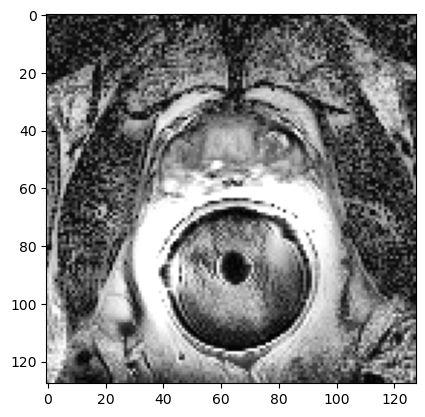

In [6]:
plt.imshow(img, cmap="gray")

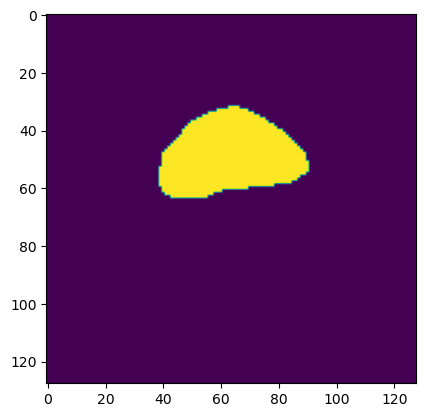

In [7]:
plt.imshow(msk)

In [8]:
#this function takes an input image and
#does the manual feature extraction
#if the variable nchan is sset to True, then the return is just the number of channels

def preprocess_img(img, nchan=False):

  #raw image and Scharr filter
  res = np.dstack( (img, scharr(img) ) )

  #add a series fo Gabor filters
  for frq in [0.2, 0.4, 0.6, 0.8]:
    for j in range(4):
      a, b = gabor(img, frq, theta=np.pi/4 * j)
      res = np.dstack( (res, np.sqrt(a**2 + b**2) ))
  #LBP
  radius = 3
  n_points = 8 * radius
  lbp = local_binary_pattern(img, n_points, radius, method='uniform')

  #difference of gaussians
  dog = difference_of_gaussians(img, low_sigma=1, high_sigma=3)

  res = np.dstack( (res, lbp, dog))

  #if nchan is True, then just return the number of channels
  #the pre-processing produces
  if nchan:
    try:
      return(res.shape[2])
    except IndexError:
      return(1)
  return (res)

In [9]:
#turn the images into a training dataset
#train_path:    path to the training data
#n_train_patch: number of patches to be extracted per image
#ps :           patch size as integer (e.g., 7 -> 7x7 patches)
#chan:          number of 'channels' the pre_processed image will have

def create_training_set(train_path, n_train_patch, ps, chan, verbose=True):
  if verbose:
    print("Extracting " + str(n_train_patch) + " pataches of size " + str(ps) + "x" + str(ps) + " from each image.")

  #dimension of square patch
  patch_dim = (ps, ps)
  #center of the patch
  patch_cnt = int((ps-1)/2)
  #dimension of the 'flattened' patch

  flat_dim = ps*ps*chan

  #initialize Y and X
  Y = []
  X = np.empty((0,flat_dim))

  for s in np.arange(30):
    if verbose:
      print("Extracting data from subject: " + str(s))

    img_m, msk_x = rimg(train_path, s)

    #binarize the mask
    msk = (msk_x > 0) * 1

    #extract features
    frames = preprocess_img(img_m)
    #add the labels as an additional channel
    frames = np.dstack((frames, msk))

    #sample patches
    patch = image.extract_patches_2d(frames, patch_dim, max_patches=n_train_patch)

    #each patch receives the label of the center value in the 'label' channel
    Y_tmp = patch[:,patch_cnt,patch_cnt,chan] == 1
    #turn patches into a matrix where each row corresponds to all the features
    #of one patch
    X_tmp = np.reshape(patch[:,:,:,0:chan],(n_train_patch,flat_dim))

    #concatenate with Y and X
    Y.extend(Y_tmp)
    X = np.concatenate((X, X_tmp), axis=0)

    #clear some memory
    patch = None
    X_tmp = None
    Y_tmp = None
    gc.collect()
  return (Y, X)

In [10]:
#this function takes X and Y as input and
#oversamples the target class ('1') with a ratio:1 ratio (default: None)
# if ratio is None, then it will be set to 1/f, where f is the frequency
# of the target class
#from the overall size of X a sub_sample of 'sample_size' is randomly selected
def sub_sample(X, Y, sample_size=10000, ratio=None):
    #compute class 1 frequency
    rtclass = np.sum(Y)/len(Y)
    if ratio is None:
        ratio = 1.0/rtclass
        print("sampling with ratio 1:" + str(ratio))
    weights = np.array([1] * len(Y))
    weights[Y] = ratio
    weights = weights/np.sum(weights)

    #sample sample_size of the generated patches
    idx = np.random.choice(X.shape[0],sample_size,replace=False, p=np.array(weights))

    Xsub = X[idx,:]
    Ysub = np.array(Y)[idx]

    #return subsets of X, Y and the selection index
    return Xsub, Ysub, idx

In [11]:
#set number of patches
#set patch size
n_train_patch = 1000
ps = 21

In [12]:
#get the number of channels
nchan = preprocess_img(img, True)

In [13]:
#create the dataset from the 30 training images
Y, X = create_training_set(train_path, n_train_patch, ps, nchan)

Extracting 1000 pataches of size 21x21 from each image.
Extracting data from subject: 0
Extracting data from subject: 1
Extracting data from subject: 2
Extracting data from subject: 3
Extracting data from subject: 4
Extracting data from subject: 5
Extracting data from subject: 6
Extracting data from subject: 7
Extracting data from subject: 8
Extracting data from subject: 9
Extracting data from subject: 10
Extracting data from subject: 11
Extracting data from subject: 12
Extracting data from subject: 13
Extracting data from subject: 14
Extracting data from subject: 15
Extracting data from subject: 16
Extracting data from subject: 17
Extracting data from subject: 18
Extracting data from subject: 19
Extracting data from subject: 20
Extracting data from subject: 21
Extracting data from subject: 22
Extracting data from subject: 23
Extracting data from subject: 24
Extracting data from subject: 25
Extracting data from subject: 26
Extracting data from subject: 27
Extracting data from subject: 

In [14]:
#subsample as per instructions
Xsub, Ysub, sub_idx = sub_sample(X, Y, 1000)

sampling with ratio 1:9.339975093399751


In [15]:
#the initial X and Y matrices are quite large and
#clutter the memory, we don't require these for further processing
#so setting them to None and calling the garbage collector
#will preserve resources
import gc
X = None
Y = None
gc.collect()

0

## (a) Train SVC with linear, polynomial and RBF kernel

Training with kernel=rbf, C=0.1
Training with kernel=rbf, C=1
Training with kernel=rbf, C=10
Training with kernel=rbf, C=100
Training with kernel=rbf, C=1000
Training with kernel=poly, C=0.1
Training with kernel=poly, C=1
Training with kernel=poly, C=10
Training with kernel=poly, C=100
Training with kernel=poly, C=1000


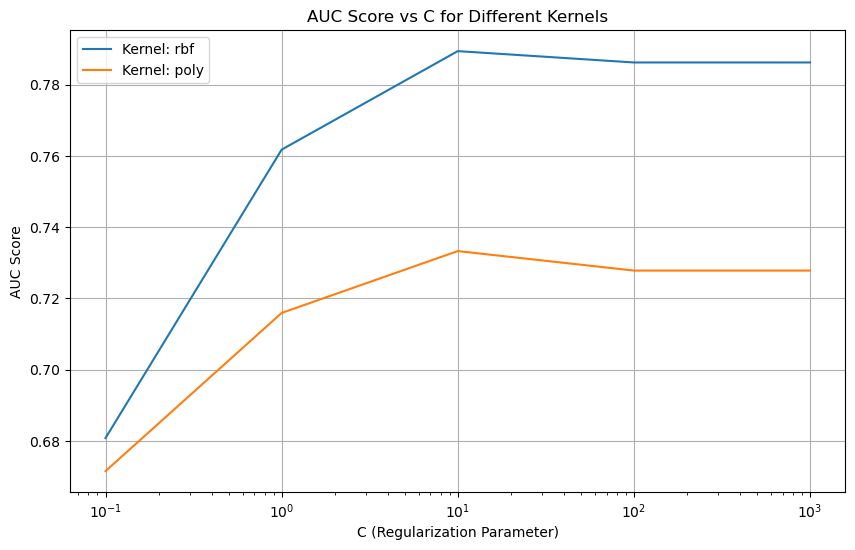

In [16]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve

# Split the balanced dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(Xsub, Ysub, test_size=0.3, random_state=42)

# Define parameter grid
C_values = [0.1, 1, 10, 100, 1000]
kernels = ['rbf', 'poly']
auc_scores = {kernel: [] for kernel in kernels}

# Train and evaluate the model for different kernels and C values
for kernel in kernels:
    for C in C_values:
        print(f"Training with kernel={kernel}, C={C}")
        if kernel == 'poly':
            model = SVC(kernel=kernel, C=C, degree=3, probability=True, random_state=42)
        else:
            model = SVC(kernel=kernel, C=C, probability=True, random_state=42)
        
        
        cv_auc = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc').mean()
        auc_scores[kernel].append(cv_auc)

plt.figure(figsize=(10, 6))
for kernel in kernels:
    plt.plot(C_values, auc_scores[kernel], label=f"Kernel: {kernel}")
plt.xscale('log')
plt.xlabel("C (Regularization Parameter)")
plt.ylabel("AUC Score")
plt.title("AUC Score vs C for Different Kernels")
plt.legend()
plt.grid()
plt.show()

## (b) Apply to validation data, compute DICE and AUC

In [ ]:

import numpy as np
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.feature_extraction import image

# Function to compute DICE coefficient
def dice_coefficient(y_true, y_pred):
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    intersection = np.sum(y_true * y_pred)
    return 2.0 * intersection / (np.sum(y_true) + np.sum(y_pred))

# Train the best model using optimal parameters
print("Training the SVC model with RBF kernel and C=10...")
best_model = SVC(kernel='rbf', C=10, probability=True, random_state=42)
best_model.fit(Xsub, Ysub)  # Use the balanced training subset
print("Model training complete.")

# Initialize metrics and storage for validation results
dice_scores = []
roc_aucs = []
validation_results = []

# Patch size and center for prediction
patch_size = 21
patch_center = patch_size // 2

# Process validation images (img_30_15.png to img_39_15.png)
print("Starting validation...")
for i in range(30, 40):  # Validation images range from 30 to 39
    print(f"Processing validation image {i}...")
    
    # Construct file paths for validation images and masks
    img_file = f"{vali_path}img_{str(i).zfill(2)}_15.png"
    mask_file = f"{vali_path}lab_{str(i).zfill(2)}_15.png"
    
    # Load validation image and mask
    img_val = imageio.v3.imread(img_file)
    mask_val = imageio.v3.imread(mask_file)
    print(f"Loaded image: {img_file} and mask: {mask_file}")
    
    # Preprocess validation image for feature extraction
    features_val = preprocess_img(img_val)
    print(f"Preprocessed image {i} to {features_val.shape[2]} feature channels.")
    
    # Extract patches for prediction
    print(f"Extracting patches from validation image {i}...")
    patches = image.extract_patches_2d(features_val, (patch_size, patch_size))
    patches_reshaped = patches.reshape(patches.shape[0], -1)
    print(f"Extracted {patches.shape[0]} patches.")

    # Predict segmentation for each patch
    print(f"Making predictions for validation image {i}...")
    pred_patches = best_model.predict(patches_reshaped)
    
    # Reconstruct the predicted segmentation
    print(f"Reconstructing segmentation for validation image {i}...")
    pred_segmentation = np.zeros_like(img_val, dtype=int)
    patch_idx = 0
    for x in range(patch_center, 128 - patch_center):
        for y in range(patch_center, 128 - patch_center):
            pred_segmentation[x, y] = pred_patches[patch_idx]
            patch_idx += 1
    
    # Compute DICE coefficient
    dice = dice_coefficient(mask_val, pred_segmentation)
    dice_scores.append(dice)
    print(f"DICE coefficient for image {i}: {dice:.4f}")
    
    # Compute ROC-AUC
    roc_auc = roc_auc_score(mask_val.flatten(), pred_segmentation.flatten())
    roc_aucs.append(roc_auc)
    print(f"ROC-AUC for image {i}: {roc_auc:.4f}")
    
    # Store results for visualization
    validation_results.append((img_val, mask_val, pred_segmentation))
    print(f"Validation image {i} processed.\n")

# Visualize 5 validation results
print("Visualizing results for 5 validation images...")
for i, (img, mask, pred) in enumerate(validation_results[:5]):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(img, cmap='gray')
    plt.title("Original Image")
    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap='gray')
    plt.title("Ground Truth")
    plt.subplot(1, 3, 3)
    plt.imshow(pred, cmap='gray')
    plt.title("Predicted Segmentation")
    plt.show()

# Compute and display average metrics
avg_dice = np.mean(dice_scores)
avg_roc_auc = np.mean(roc_aucs)

print("\nValidation complete.")
print(f"Average DICE Coefficient: {avg_dice:.4f}")
print(f"Average ROC-AUC: {avg_roc_auc:.4f}")




Training the SVC model with RBF kernel and C=10...
Model training complete.
Starting validation...
Processing validation image 30...
Loaded image: ./validate/img_30_15.png and mask: ./validate/lab_30_15.png
Preprocessed image 30 to 20 feature channels.
Extracting patches from validation image 30...
Extracted 11664 patches.
Making predictions for validation image 30...
Reconstructing segmentation for validation image 30...
DICE coefficient for image 30: 0.2672
ROC-AUC for image 30: 0.6976
Validation image 30 processed.

Processing validation image 31...
Loaded image: ./validate/img_31_15.png and mask: ./validate/lab_31_15.png
Preprocessed image 31 to 20 feature channels.
Extracting patches from validation image 31...
Extracted 11664 patches.
Making predictions for validation image 31...
Reconstructing segmentation for validation image 31...
DICE coefficient for image 31: 0.3686
ROC-AUC for image 31: 0.7428
Validation image 31 processed.

Processing validation image 32...
Loaded image: .

## (c) train a tree-based classifier

## (d) Explore sample / patch sizes

## (e) Prediction post-processing

## (f) apply to test set